We did some exploratory analysis on the dataset we had earlier. I think it's time that we start doing some modeling, and the best model to start with in my opinion is linear regression. It's super simple to understand and is very fast to run. We have to recognize that we do not have all of the data we'd like but we can start with the small partition that I've downloaded. 

From our notes earlier, we saw that 

In [17]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from functools import lru_cache

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import fsolve, minimize, newton

In [2]:
data = pd.read_parquet("train_partition_0.parquet")

In [3]:
def get_top_features_by_correlation(features: pd.DataFrame, target: pd.Series, threshold: float = None, N: int = None) -> pd.DataFrame:
    """
    Selects and returns the top features from a DataFrame based on their correlation with a target Series.
    
    Parameters:
    features (pd.DataFrame): A DataFrame containing the feature set.
    target (pd.Series): A Series representing the target variable.
    threshold (float, optional): A float value representing the correlation threshold. Features with an absolute correlation
                                 value greater than this threshold will be selected.
    N (int, optional): An integer value representing the number of top features to select based on absolute correlation.
                          If both threshold and topN are provided, topN will take precedence.
    
    Returns:
    pd.DataFrame: A DataFrame containing the top features based on the specified criteria.
    """
    correlation_matrix = features.corrwith(target)
    
    if N:
        top_features = correlation_matrix.abs().nlargest(N).index.tolist()
    elif threshold:
        top_features = correlation_matrix[correlation_matrix.abs() > threshold].index.tolist()
    else:
        raise ValueError("Either threshold or topN must be provided.")
    
    return features[top_features]

In [4]:
features = data.filter(like='feature')
target = data['responder_6']

In [5]:
top_features = get_top_features_by_correlation(features, target, N=10)
top_features.columns

Index(['feature_06', 'feature_07', 'feature_05', 'feature_68', 'feature_51',
       'feature_19', 'feature_08', 'feature_69', 'feature_56', 'feature_13'],
      dtype='object')

In [21]:
top_features_sample = top_features.sample(frac=0.10)
test_features_sample = top_features.drop(top_features_sample.index).sample(frac=0.02)

train_target = target[top_features_sample.index]
test_target = target[test_features_sample.index]

train_weights = data['weight'][train_target.index]
test_weights = data['weight'][test_target.index]

In [18]:
# Then we are going to feature scale here --> going to use standard scaling for this task 
feature_scaler = StandardScaler() 
top_features_sampled_scaled = feature_scaler.fit_transform(top_features_sample)
test_features_sampled_scaled = feature_scaler.transform(test_features_sample)

In [29]:
# Creating a beta vector of length 10
beta = np.random.rand(10)

prediction = np.dot(beta, top_features_sampled_scaled.T)

# Then we are going to calculate the difference between the prediction and the target
difference = prediction - train_target
metric = 1 - np.sum(train_weights * difference ** 2) / (np.sum(train_weights * train_target ** 2))

In [59]:
def calculate_loss(beta, X, y, weights):
    prediction = np.dot(beta, X.T)
    difference = prediction - y
    numerator = np.sum(weights * difference ** 2)
    denominator = np.sum(weights * y ** 2)
    return -(1 - numerator / denominator) 

In [60]:
# Then we are going to use the scipy.optimize.minimize function to minimize the loss function
result = minimize(calculate_loss, x0=np.random.rand(10), args=(top_features_sampled_scaled, train_target, train_weights))

In [61]:
result.x 

array([ 0.00164274,  0.00128368,  0.00024537,  0.00286674,  0.00121096,
        0.0017376 ,  0.00424761,  0.001973  ,  0.00069582, -0.00451175])

In [67]:
# Then we are going to calculate the loss on the test set
train_loss = calculate_loss(result.x, top_features_sampled_scaled, train_target, train_weights)
test_loss = calculate_loss(result.x, test_features_sampled_scaled, test_target, test_weights)

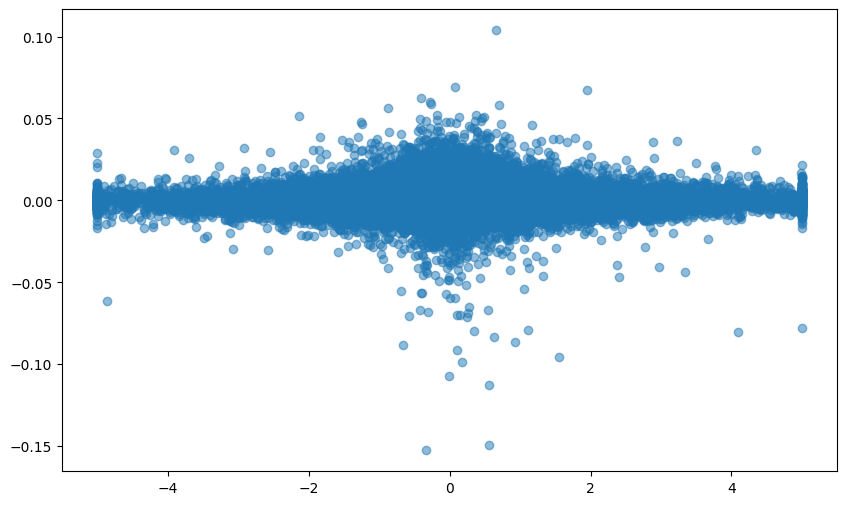

In [64]:
# Visulating the training predictions and the target using the new beta values
prediction = np.dot(result.x, top_features_sampled_scaled.T)
plt.figure(figsize=(10, 6))
plt.scatter(train_target, prediction, alpha=0.5)
plt.show() 

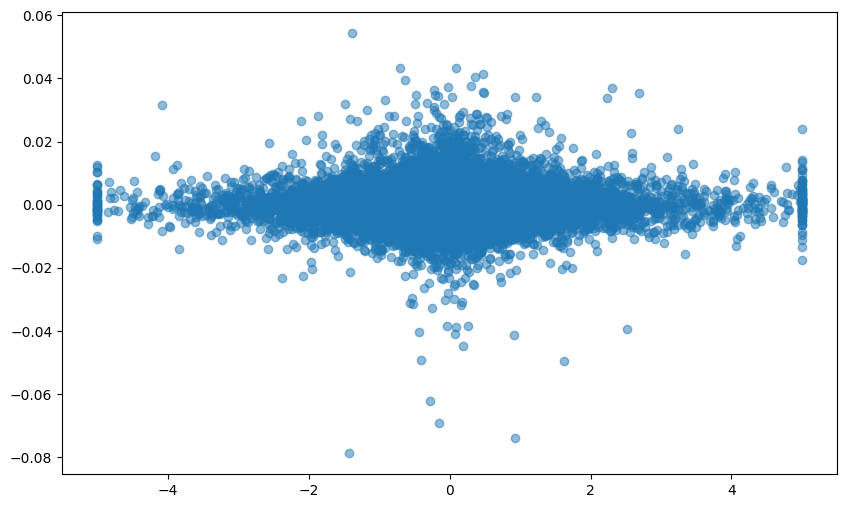

In [65]:
# Doing the same with the test set 
prediction = np.dot(result.x, test_features_sampled_scaled.T)
plt.figure(figsize=(10, 6))
plt.scatter(test_target, prediction, alpha=0.5)
plt.show()

In [70]:
result.x

array([ 0.00164274,  0.00128368,  0.00024537,  0.00286674,  0.00121096,
        0.0017376 ,  0.00424761,  0.001973  ,  0.00069582, -0.00451175])

In [71]:
top_features_sample.head()

,feature_06,feature_07,feature_05,feature_68,feature_51,feature_19,feature_08,feature_69,feature_56,feature_13
47534,-2.585557,-2.314538,-0.676924,-0.066184,1.302037,-0.506445,-0.224024,1.638110,-0.894722,-0.195271
1511501,0.215412,0.407565,0.173839,-0.381368,0.208241,-1.540574,0.133626,-0.325986,-0.110097,-0.400701
1856142,0.892134,4.432067,4.657217,0.157295,-0.330824,-0.109766,-1.173700,1.348262,1.084525,0.327747
1514747,-0.325049,-0.079545,-0.053814,-0.504105,-2.411194,1.308652,0.105346,-0.672915,0.675200,-0.393098
894646,0.367252,-0.436910,-0.243669,-0.433068,-1.889150,1.630604,0.414889,-0.477391,1.858217,-0.616387


Some ending ntoes from this analysis

We should try running this on a larger sample of data potentially. Even work towards running analysis on all of the data. Might have to set up a job to run through chunks of the data. 

We are not getting the greatest model in the world but we can throw it in there to see how it does. The parameters are: 
* feature_06 -> 0.00164274 
* feature_07 -> 0.00128368
* feature_05 -> .....

we are going to have to hard code this model in the kaggle notebook. Not sure how we can put other types of models in there. 